# Notes
* The precalculated ratings used in this example should first be downloaded from
https://data.openei.org/submissions/6231
* Make sure to use the `dlr` conda environment when running this notebook

# Imports

In [1]:
#%% Imports
import numpy as np
import pandas as pd
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
import pyproj
import folium
from tqdm import tqdm
## Local
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from dlr import helpers
from dlr import paths
from dlr import physics
from dlr import plots
plots.plotparams()
pyproj.network.set_network_enabled(False)
pd.options.display.max_columns = 200
pd.options.display.max_rows = 30

# Example data queries
First download data from https://data.openei.org/submissions/6231 and save to `paths.ratings`

In [3]:
fpath_dlr = os.path.join(paths.ratings, 'DLR_SLR_ratio-75C.h5')

### One line, all timestamps
helpers.get_ratings(fpath=fpath_dlr, ids=202132)

time_index
2007-01-01 00:00:00+00:00    1.526209
2007-01-01 01:00:00+00:00    1.486916
2007-01-01 02:00:00+00:00    1.486763
2007-01-01 03:00:00+00:00    1.485284
2007-01-01 04:00:00+00:00    1.515671
                               ...   
2013-12-31 19:00:00+00:00    1.886873
2013-12-31 20:00:00+00:00    1.742393
2013-12-31 21:00:00+00:00    1.295943
2013-12-31 22:00:00+00:00    1.363414
2013-12-31 23:00:00+00:00    1.675393
Freq: h, Name: 202132, Length: 61368, dtype: float32

In [4]:
### One timestamp, all lines
helpers.get_ratings(fpath=fpath_dlr, timestamps='2012-10-04 12:00-0600')

ID
100001    1.576117
100002    1.093155
100004    1.877311
100005    1.548969
100006    2.232544
            ...   
313970    1.199535
313971    1.503036
313972    1.457148
315008    1.281758
315013    2.020145
Name: 2012-10-04 18:00:00+00:00, Length: 84636, dtype: float32

In [5]:
### All timestamps, all lines (memory and time intensive)
# helpers.get_ratings(fpath=fpath_dlr)

# Map one timestamp for many lines

In [6]:
### Get HIFLD routes and calculate SLR
temp_conductor = 75
slr_kwargs={'temp_conductor':temp_conductor+physics.C2K}
dfhifld = helpers.get_hifld(
    calc_slr=True,
    calc_zlr=True, regional_air_temp={'summer':40, 'winter':20},
    slr_kwargs=slr_kwargs,
    ## Limit to high-voltage (≥115 kV) lines
    ## but don't apply usual ≤50-mile cutoff
    min_kv=115, max_miles=np.inf,
)

keepids = dfhifld.index.sort_values()
timestamp = pd.Timestamp('2012-10-04 12:00-0600')

dfrating = helpers.get_ratings(
    fpath=fpath_dlr,
    timestamps=timestamp,
).reindex(keepids).dropna()

### Get state outlines
dfmap = helpers.get_reeds_zones()

### Plot it
dfplot = dfhifld.loc[dfrating.index].copy()
dfplot['rating'] = (dfrating.index.map(dfrating) - 1) * 100

drawstates = 0.1
lw = {115: 0.5, 230:1, 345:1.5, 500:2, 765:3}
timestring = '%Y-%m-%d\n%H:%M:00 CST'

settings = {
    'rating': {
        'cmap':plots.make_cmap(vmin=-20, vmax=160, cliphi=1, cliplo=5),
        'vmin':-20, 'vmax':160},
}

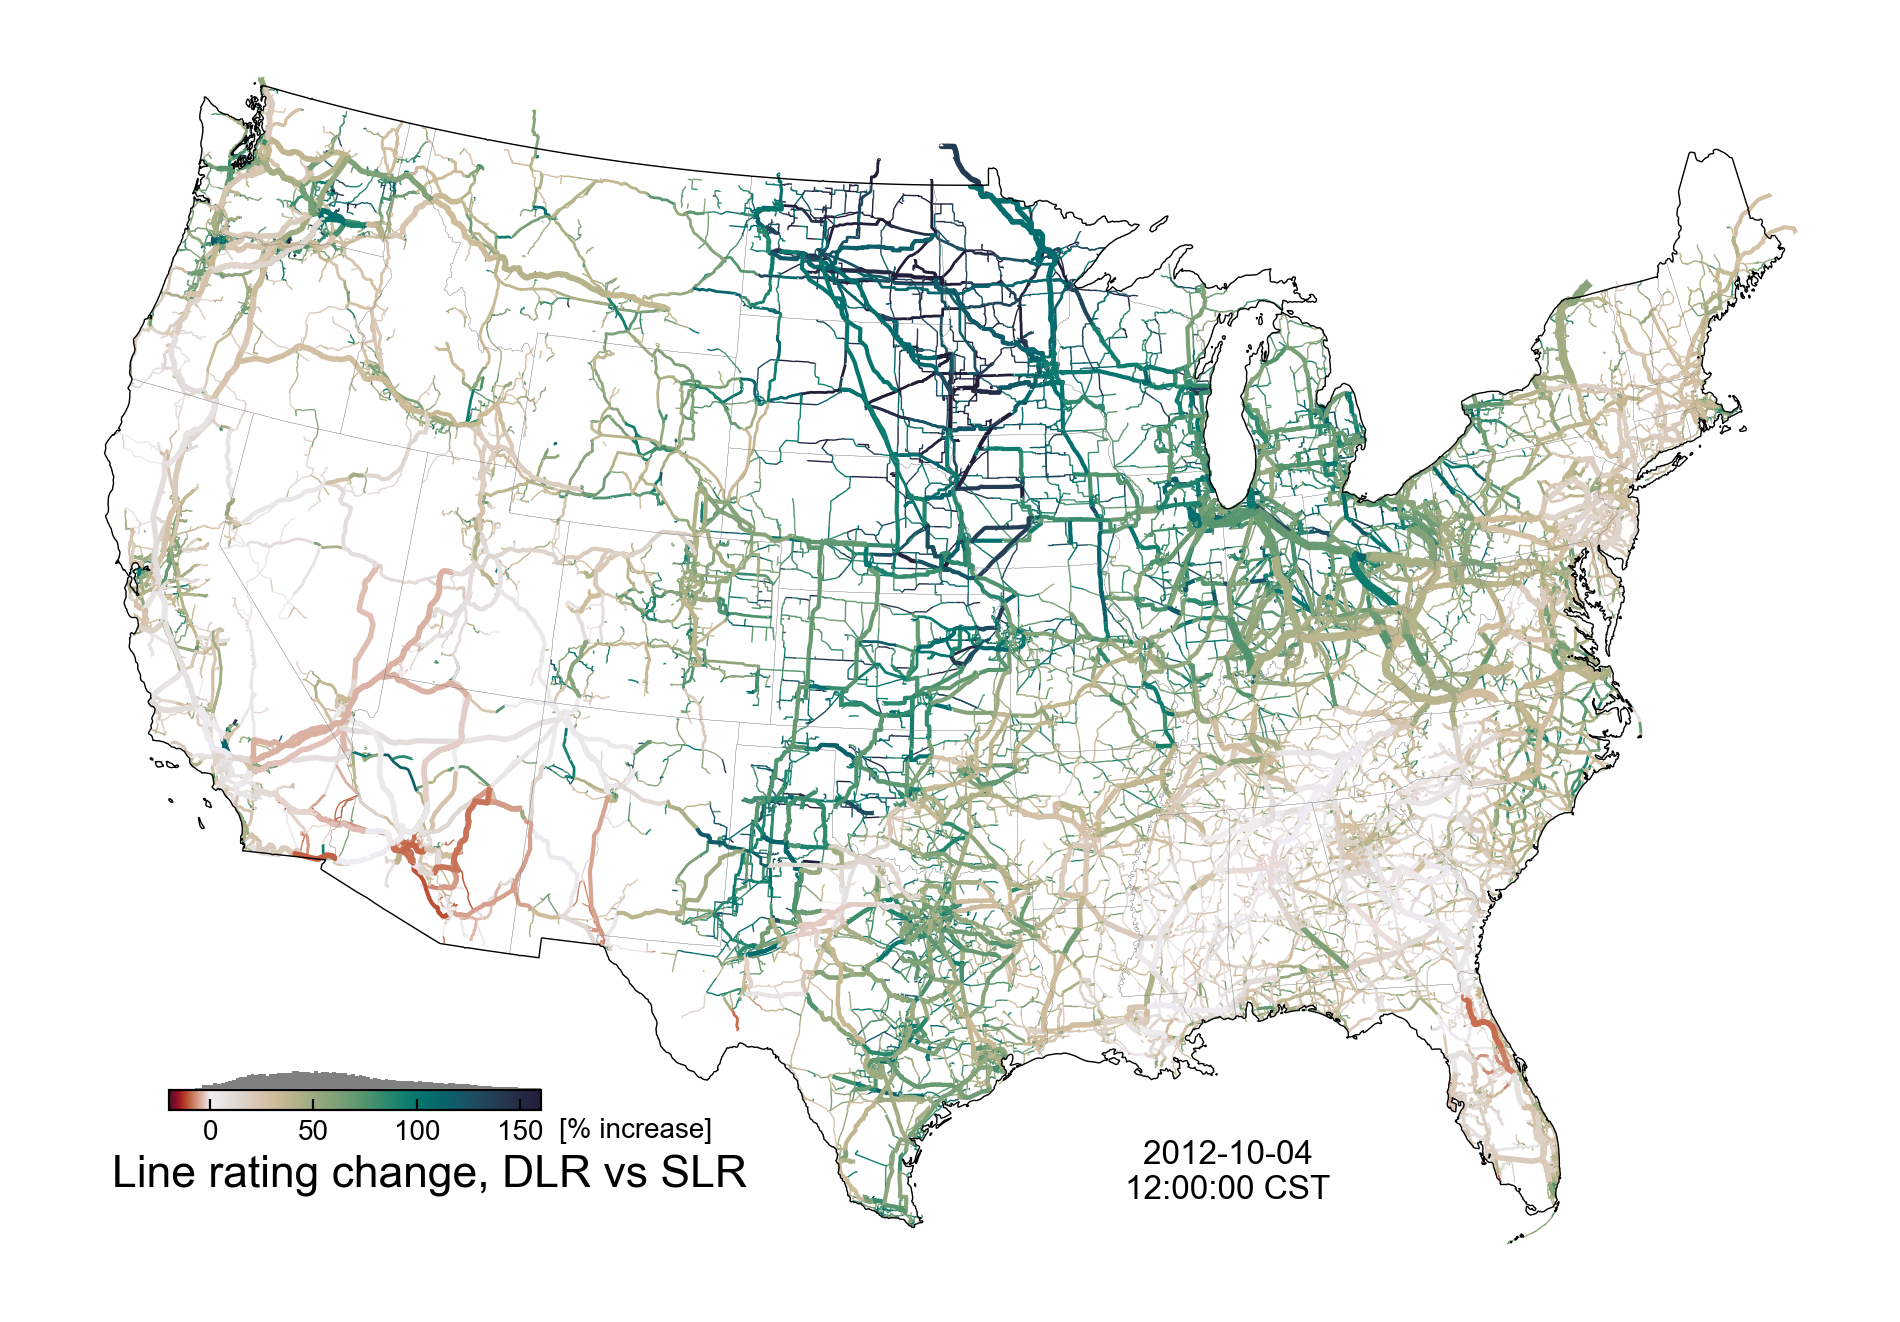

In [7]:
#%% Plot it
plt.close()
f,ax = plt.subplots(figsize=(12,9))
## Background
dfmap['country'].plot(ax=ax, facecolor='none', edgecolor='k', lw=0.5, zorder=1e8)
if drawstates:
    dfmap['st'].plot(ax=ax, facecolor='none', edgecolor='C7', lw=drawstates, zorder=1e7)
ax.axis('off')
## Line rating
for kv in lw:
    dfplot.loc[dfplot.rep_voltage==kv].sort_values('length_miles').plot(
        ax=ax, column='rating',
        cmap=settings['rating']['cmap'],
        vmin=settings['rating']['vmin'],
        vmax=settings['rating']['vmax'],
        lw=lw[kv],
    )
## Legend
cbarbottom = 0.15
plots.addcolorbarhist(
    f=f, ax0=ax, data=dfplot.rating.values,
    cmap=settings['rating']['cmap'],
    vmin=settings['rating']['vmin'],
    vmax=settings['rating']['vmax'],
    orientation='horizontal', ticklabel_fontsize='medium',
    cbarhoffset=-0.8, cbarheight=0.2, cbarbottom=cbarbottom, nbins=101,
    histratio=1, histpad=0.001, cbarwidth=0.015,
)
ax.annotate(
    '[% increase]', (0.29, cbarbottom-0.016), xycoords='axes fraction',
    ha='left', va='center', fontsize='medium',
)
ax.annotate(
    'Line rating change, DLR vs SLR',
    (0.22, 0.09), xycoords='axes fraction',
    fontsize=16, ha='center',
)
ax.annotate(
    timestamp.strftime(timestring),
    (0.68e6, -1.5e6), ha='center', va='center', fontsize=12,
)
plt.show()

# Plot all timestamps for one line

## Pick a line

In [ ]:
rep_voltages = [115, 230, 345, 500, 765]
color_voltage = dict(zip(
    rep_voltages,
    ['red', 'orange', 'green', 'blue', 'purple'],
))
lw_voltage = dict(zip(
    rep_voltages,
    [1, 2, 3, 4, 5],
))
tiles = "CartoDB positron"
m = dfmap['st'].explore(
    color='none', tiles=tiles, name='State',
    style_kwds={'color':'black', 'weight':0.2},
)
## Pick from a given voltage range
keep_voltages = [230, 345, 500, 765]
for rep_voltage in keep_voltages:
    (
        dfhifld.loc[dfhifld.rep_voltage==rep_voltage]
        .drop(columns=['SOURCEDATE','VAL_DATE'], errors='ignore')
        .round({'length_miles':1})
    ).explore(
        m=m, tooltip=['ID','VOLTAGE','length_miles'],
        style_kwds={'color':color_voltage[rep_voltage], 'weight':lw_voltage[rep_voltage]},
        name=rep_voltage
    )
folium.LayerControl().add_to(m)
m

The interactive map above won't render on github, but if run locally it will look like this:
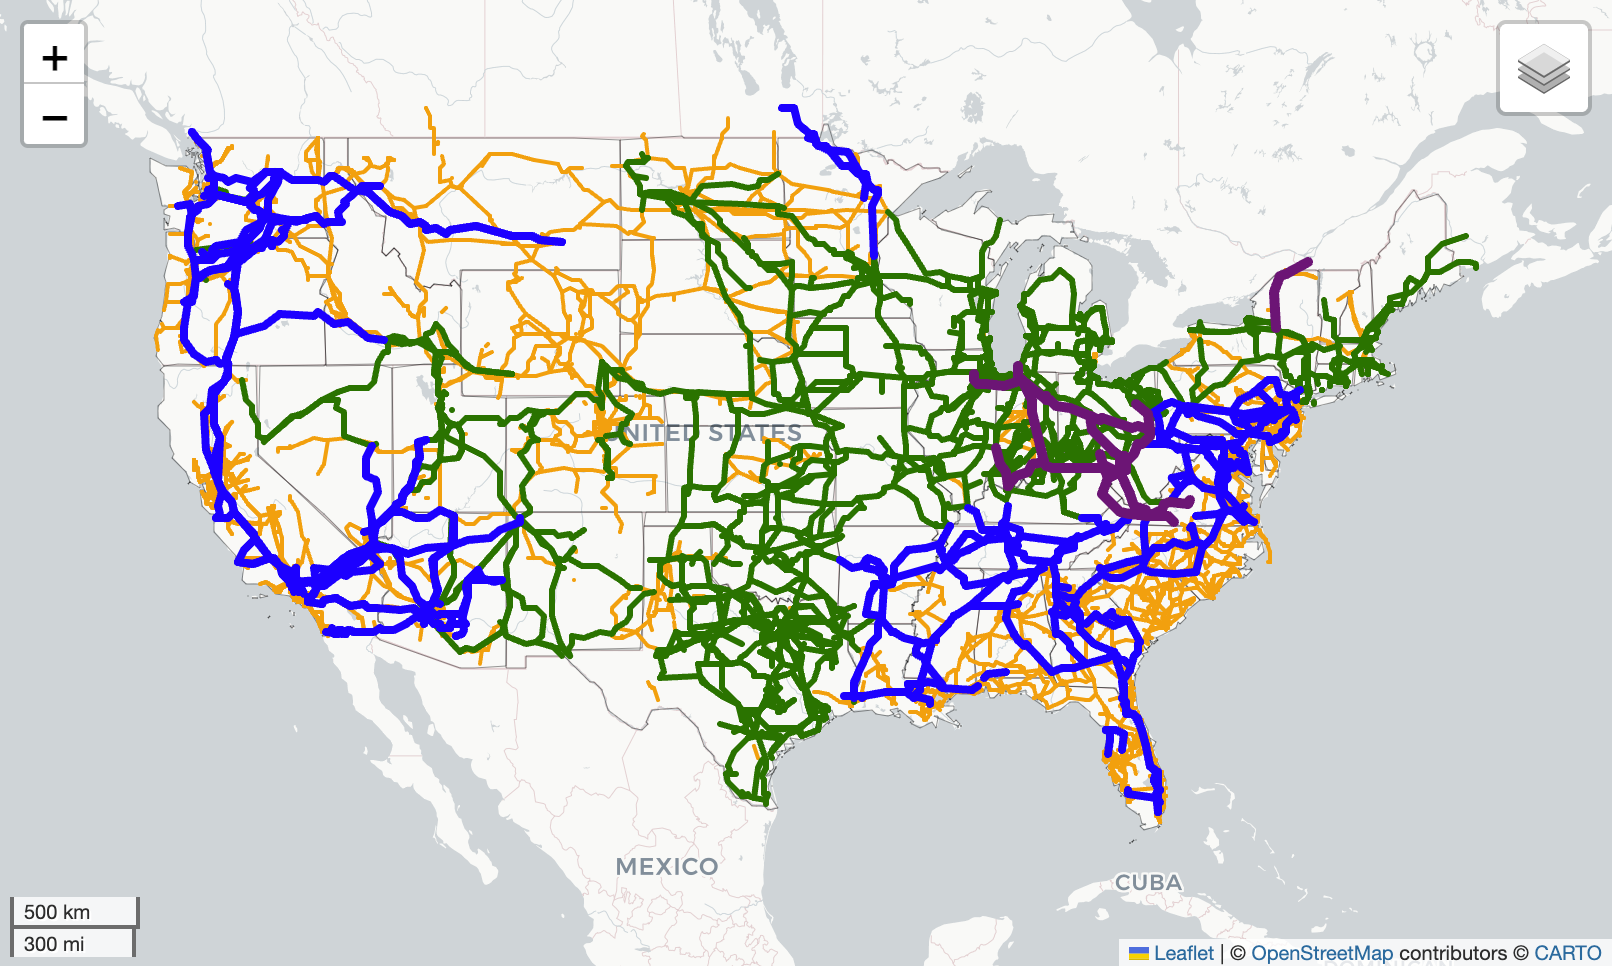

In [8]:
keepid = 202132

## Get data for plots

In [9]:
ratingfiles = {
    # 'ALR': os.path.join(paths.ratings, 'ALR_SLR_ratio-75C-2fps.h5'),
    # 'NLR': os.path.join(paths.ratings, 'NLR_SLR_ratio-75C-2fps.h5'),
    # 'CLR': os.path.join(paths.ratings, 'CLR_SLR_ratio-75C-2fps.h5'),
    # 'ILR': os.path.join(paths.ratings, 'ILR_SLR_ratio-75C-2fps.h5'),
    'ALR': os.path.join(paths.ratings, 'ALR_SLR_ratio-75C-0fps.h5'),
    'NLR': os.path.join(paths.ratings, 'NLR_SLR_ratio-75C-0fps.h5'),
    'CLR': os.path.join(paths.ratings, 'CLR_SLR_ratio-75C-0fps.h5'),
    'ILR': os.path.join(paths.ratings, 'ILR_SLR_ratio-75C-0fps.h5'),
    'DLR': os.path.join(paths.ratings, 'DLR_SLR_ratio-75C.h5'),
}

tz = 'Etc/GMT+6'

lrs = [
    'SLR',
    'ZLR',
    'ALR',
    'NLR',
    'CLR',
    'ILR',
    'DLR',
]
colors = {
    'SLR': 'k',
    'ZLR': '0.7',
    'ALR': 'C0',
    'NLR': plt.cm.tab20(3),
    'CLR': plt.cm.tab20(2),
    'ILR': 'C3',
    'DLR': 'C2',
}
lss = {
    'SLR': '-',
    'ZLR': '--',
    'ALR': '-',
    'NLR': '-',
    'CLR': '-',
    'ILR': ':',
    'DLR': '--',
}

### Get SLRs
slrfile = os.path.join(paths.ratings,f'SLR_A-{temp_conductor}C.h5')
with h5py.File(slrfile, 'r') as h:
    dfslr = pd.Series(index=h['index'], data=h['data'])

dictresults = {}
for lr, lrpath in tqdm(ratingfiles.items()):
    dictresults[lr] = (
        helpers.get_ratings(fpath=lrpath, ids=keepid).tz_convert(tz)
        * dfslr[keepid]
    )

### Make ZLR timeseries
time_index = dictresults['DLR'].index
dictresults['ZLR'] = helpers.make_zlr_timeseries(
    dfhifld=dfhifld.loc[[keepid]],
    time_index=time_index,
)
dictresults['SLR'] = pd.Series(index=time_index, data=dfslr[keepid])

dfresults = pd.concat(dictresults, axis=1, names=('LR', 'ID'))
dfresults.columns = dfresults.columns.droplevel('ID')

ymax = dfresults.max().max() * 1.03

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  5.99it/s]


## Sorted distribution of ratings

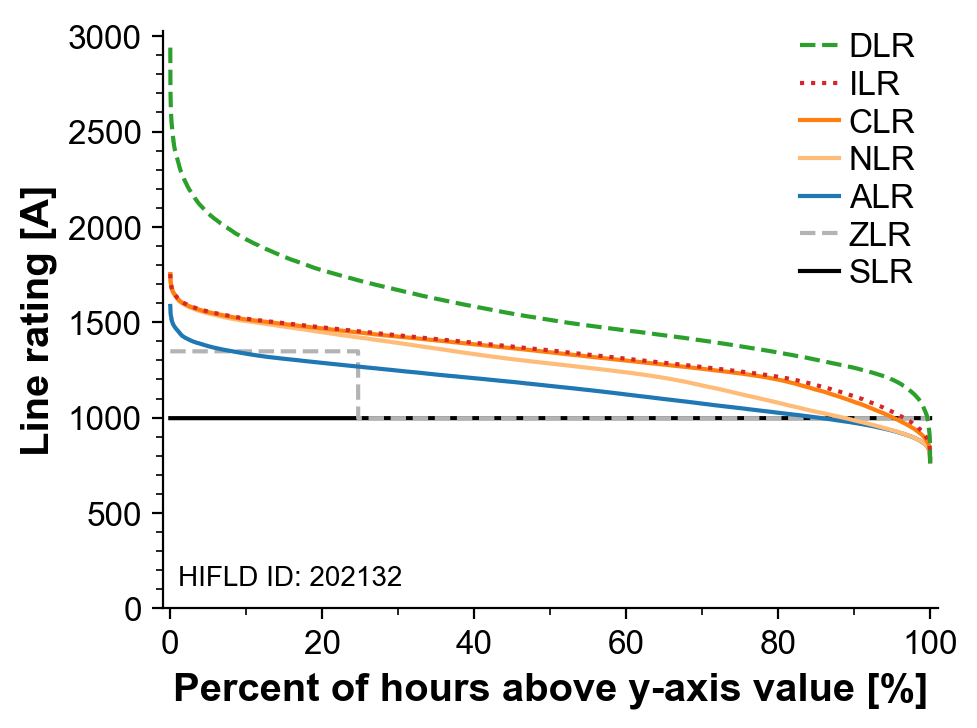

In [10]:
plt.close()
f,ax = plt.subplots()
for lr in lrs:
    ax.plot(
        np.linspace(0,100,len(dfresults)),
        dfresults[lr].sort_values(ascending=False).values,
        color=colors[lr], ls=lss[lr], label=lr,
    )
## Formatting
ax.set_ylabel('Line rating [A]')
ax.set_xlabel('Percent of hours above y-axis value [%]')
ax.set_ylim(0, ymax)
ax.set_xlim(-1,101)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(500))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
## Legend
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    handles[::-1], labels[::-1],
    loc='lower right', bbox_to_anchor=(1.01, 0.5),
    frameon=False,
    handletextpad=0.3,
    handlelength=1.15,
    columnspacing=0.5, labelspacing=0.2,
    fontsize='large',
)
ax.annotate(
    f'HIFLD ID: {keepid}',
    (0.02,0.04), xycoords='axes fraction', fontsize='medium',
)
plots.despine(ax)
plt.show()


## Timeseries

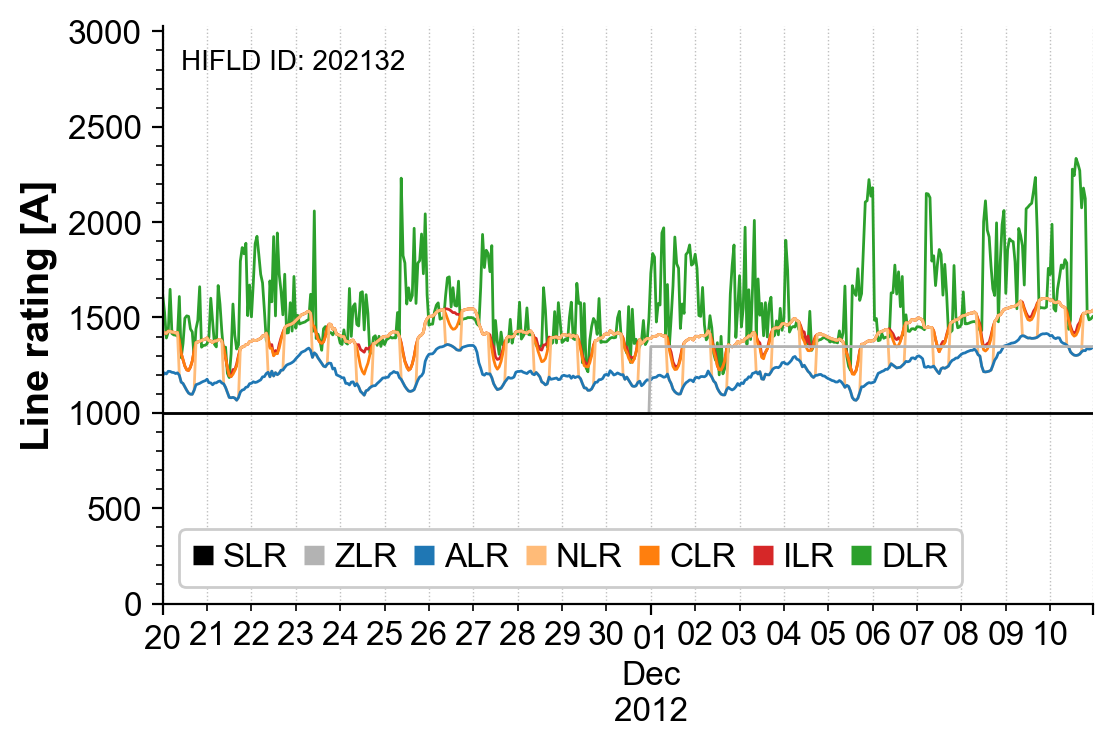

In [11]:
#%% Profile for subset of year
date1, date2 = '20121120', '20121210'
figsize = (6, 3.75)

plt.close()
f,ax = plt.subplots(figsize=figsize)
for lr in lrs[::-1]:
    dfresults[lr].loc[date1:date2].plot(
        ax=ax, color=colors[lr], lw=1.0, label=lr,
    )
ax.set_ylim(0, ymax)
ax.set_ylabel('Line rating [A]')
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(500))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
ax.grid(axis='x', which='both', c='0.75', ls=':', lw=0.5)

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    handles[::-1], labels[::-1],
    loc='lower left', ncols=len(lrs), frameon=True, framealpha=1,
    handletextpad=0.3, handlelength=0.6,
    columnspacing=0.5, labelspacing=0.2,
    fontsize='large',
)
for legobj in leg.legend_handles:
    legobj.set_linewidth(7)
    legobj.set_solid_capstyle('butt')
ax.annotate(
    f'HIFLD ID: {keepid}',
    (0.02,0.96), xycoords='axes fraction', fontsize='medium', va='top',
)
plots.despine(ax)
plt.show()